# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

Menozzi Luca s330802

In [121]:
import numpy as np
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

Here, you can define the values for **mode** and **instance**. 

- **INSTANCE** allows you to choose one of the six instances available in the lab.
- **MODE** can be set to either 1 or 2:
  - **1:** Utilize an algorithm to determine the initial solution before optimizing it.
  - **2:** Focus solely on the optimization process, beginning with a complete solution.

In [122]:
INSTANCE = 6
MODE = 2

if INSTANCE == 0:
    UNIVERSE_SIZE = 10_000
    NUM_SETS = 1_000
    DENSITY = 0.08
elif INSTANCE == 1:
    UNIVERSE_SIZE = 100
    NUM_SETS = 10
    DENSITY = 0.2
elif INSTANCE == 2:
    UNIVERSE_SIZE = 1_000
    NUM_SETS = 100
    DENSITY = 0.2
elif INSTANCE == 3:
    UNIVERSE_SIZE = 10_000
    NUM_SETS = 1_000
    DENSITY = 0.2
elif INSTANCE == 4:
    UNIVERSE_SIZE = 100_000
    NUM_SETS = 10_000
    DENSITY = 0.1
elif INSTANCE == 5:
    UNIVERSE_SIZE = 100_000
    NUM_SETS = 10_000
    DENSITY = 0.2
elif INSTANCE == 6:
    UNIVERSE_SIZE = 100_000
    NUM_SETS = 10_000
    DENSITY = 0.3
else:
    print("Invalid instance")
    exit(1)



rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [123]:
# DON'T EDIT THESE LINES!
# generate the sets
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)
# check if the costs is equal to 0 

In [124]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    return (valid(solution), -cost(solution)) # tuple, the first element is always the first one checked


## Initialization Algorithm

This algorithm is designed to initialize the solution using an already good solution, simplifying the optimization process. It is only applicable when **MODE** is set to 1. The approach involves the following steps:

- Begin by counting how many elements from the universe are covered by each set.
  - This operation is performed in parallel using threads.
- After calculating the **uncovered_element_per_set**, determine the ratio between the number of covered elements and the cost of each set.
- Select the most optimal set based on this ratio.
- Repeat this process until all items in the universe are covered.

In [125]:

if MODE == 1:
    # solution = all sets
    solution = np.full(NUM_SETS, True)
    all_sets_fitness = fitness(solution)
    print("all sets solution", all_sets_fitness)
    print("number of sets", NUM_SETS)

    # index of sets in the solution
    solution_idx = []

    # elements to cover, initially all the universe
    element_to_cover = np.ones(UNIVERSE_SIZE, dtype=bool)

    while not np.all(element_to_cover == False):

        # Count how many uncovered elements each set covers.
        def calculate_uncovered(idx):
            return np.sum(SETS[idx, element_to_cover])

        # Calculate how many uncovered elements each set covers.
        with ThreadPoolExecutor() as executor:
            uncovered_elements_per_set = list(executor.map(calculate_uncovered, range(NUM_SETS)))

        uncovered_elements_per_set = np.array(uncovered_elements_per_set)
        
        # calculate the ratio between the number of uncovered elements that the set cover and the cost of the set
        # hoping COSTS is not 0
        ratio = uncovered_elements_per_set / COSTS

        # Find the set that covers the most uncovered elements per cost.
        max = 0
        for i in range (len(ratio)):
            if ratio[i] > max:
                max = ratio[i]
                set_index = i
        
        # Update the solution and the elements to cover.
        solution_idx.append(set_index)
        element_to_cover &= ~SETS[set_index]


    solution = np.zeros(NUM_SETS, dtype=bool)   
    for i in range(len(solution_idx)):
        solution[solution_idx[i]] = True

    print("initial solution", fitness(solution))
    print("number of sets", len(solution_idx))

## Optimization Code

This section contains the code used to optimize the solution. 

- If **MODE** is set to 1, the code will begin with a pre-existing, well-performing solution provided by the previous function.
- If **MODE** is set to 2, the code will start from a complete solution.

### Steps:

1. Generate as many threads as there are sets to analyze (up to **MAX_SET** if **MODE** is 2; otherwise, use **n**).
2. Each thread will:
   - Generate a random value between 0.1 and 1.
   - Use this value as a probability to create a mask.
   - Some threads will apply the AND operation, while others will use XOR on the solution with the mask.
   - If the solution is acceptable, return it; otherwise, return null.
3. Once the results from the threads are collected, calculate the acceptance probability based on simulated annealing:
   - If the new fitness is better than the previous one, the acceptance probability will be 100%. Otherwise, it will depend on the previous data, current data, and temperature.
4. Based on the acceptance probability, decide whether to add the new solution to the collection of found solutions.

The algorithm will terminate once the temperature drops below the **minimum_temp** value or when all threads have finished executing.

---

**Note:** In **MODE 1**, it's possible that this code may not find any solution better than the previously found one. In **MODE 2**, it may take some time to complete the process.

In [126]:
def tweak_solution(i, current_solution):
    if stop:
        return None, None, i
    new_solution = current_solution.copy()

    # Apply changes randomly with a 10% probability.
    prob = rng.random()
    mask = rng.random(NUM_SETS) < prob
    if i % 2 == 0:
        new_solution = np.logical_xor(new_solution, mask)
    else:
        new_solution = np.logical_and(new_solution, mask)
    
    # Check if the new solution is valid.
    new_fitness = fitness(new_solution)
    if new_fitness[0] == False:
        return None, None, i

    return new_solution, new_fitness, i

def acceptance_probability(old_fitness, new_fitness, temperature):
    # calculate the acceptance probability for simulated annealing
    if new_fitness > old_fitness:
        return 1.0
    return math.exp((new_fitness[1] - old_fitness[1]) / temperature)

# Simulated Annealing parameters
initial_temperature = 100.0
cooling_rate = 0.99
min_temperature = 1e-4
temperature = initial_temperature

if MODE == 2:
    solution = np.full(NUM_SETS, True)
    n = NUM_SETS
elif MODE == 1:
    # solution already calculated in the previous cell
    n = np.count_nonzero(solution)

current_fitness = fitness(solution)
history = [(current_fitness[1], False)] # append only the cost


print("Initial solution fitness:", current_fitness)
print("Number of sets:", n)
print("------------------------------")
print('Optimization with simulated annealing...')

stop = False

# Use ThreadPoolExecutor for parallel execution of the inner loop.
with ThreadPoolExecutor(max_workers=4) as executor:
    #for step in tqdm(range(n)):
    futures = [executor.submit(tweak_solution, i, solution) for i in range(n)]
    
    # Process the results as they complete.
    for future in as_completed(futures):
        try:
            new_solution, new_fitness, i = future.result()

            if new_solution is None:
                continue
            
            # Calculate the acceptance probability
            ap = acceptance_probability(current_fitness, new_fitness, temperature)
            
            # Accept the new solution with a certain probability
            if np.random.rand() < ap:

                # check if the solution has been accepted using simulated annealing
                if new_fitness[1] < current_fitness[1]:
                    sa = True
                else:
                    sa = False

                solution = new_solution
                current_fitness = new_fitness
                print(f"TH {i}, fitness: {current_fitness}, SA: {sa}")
                history.append((current_fitness[1], sa))
            
            # Cool down the temperature after all futures processed
            temperature *= cooling_rate
            
            #print(f"Temperature: {temperature}")
            if temperature < min_temperature:
                print("Minimum temperature reached, stopping optimization.")
                stop = True
                break
            
        except Exception as e:
            print(f"Error in thread execution: {e}")

print("------------------------------")
print("Final fitness:", current_fitness)
n = np.count_nonzero(solution)
print("Number of sets:", n)



Initial solution fitness: (np.True_, np.float64(-1560722.4486846493))
Number of sets: 1000
------------------------------
Optimization with simulated annealing...
TH 4, fitness: (np.True_, np.float64(-950487.4328503492)), SA: False
TH 8, fitness: (np.True_, np.float64(-866392.9634105649)), SA: False
TH 2, fitness: (np.True_, np.float64(-455957.2297558833)), SA: False
TH 20, fitness: (np.True_, np.float64(-249943.0801328231)), SA: False
TH 17, fitness: (np.True_, np.float64(-240673.14523203782)), SA: False
TH 106, fitness: (np.True_, np.float64(-209100.7224820958)), SA: False
TH 113, fitness: (np.True_, np.float64(-181313.3923461165)), SA: False
TH 207, fitness: (np.True_, np.float64(-177743.3901530256)), SA: False
TH 343, fitness: (np.True_, np.float64(-173144.99028979067)), SA: False
TH 692, fitness: (np.True_, np.float64(-166898.64579492155)), SA: False
TH 863, fitness: (np.True_, np.float64(-166645.32619498638)), SA: False
------------------------------
Final fitness: (np.True_, np.

## Plot

Plot the data on a graph with the following specifications:

- **X-axis:** Represents the number of solutions.
- **Y-axis:** Represents the cost of the solutions.

- Points that are colored blue indicate that the solution was accepted through simulated annealing.

---

**Note:** The first solution value has been removed, as it generally incurs a significantly higher cost compared to the other solutions, which could skew the scale of the graph.

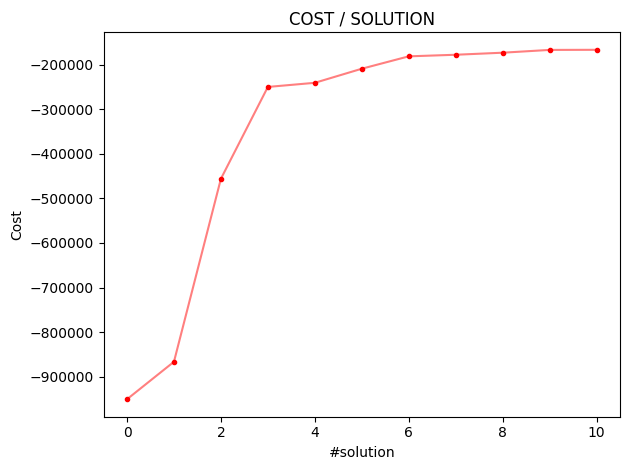

In [127]:
history.pop(0) # remove the initial solution which should have a very high cost

# if the solution has been accepted using simulated annealing, the dot is blue, otherwise red
for i, (value, flag) in enumerate(history):
    color = "blue" if flag else "red"
    plt.scatter(i, value, color=color, marker=".")

plt.plot(range(len(history)), [val[0] for val in history], color="red", alpha=0.5)

plt.title("COST / SOLUTION")
plt.xlabel("#solution")
plt.ylabel("Cost")

plt.tight_layout()
plt.show()